In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

acc_df = pd.read_parquet("/content/drive/MyDrive/Data-Mining/Tmp/accident1.parquet")
veh_df  = pd.read_parquet("/content/drive/MyDrive/Data-Mining/Tmp/vehicle1.parquet")
per_df    = pd.read_parquet("/content/drive/MyDrive/Data-Mining/Tmp/person1.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
import pandas as pd

# 1. Merge accident + vehicle
common_acc_veh = acc_df.columns.intersection(veh_df.columns)
veh_keep_keys = ["ST_CASE"]
veh_drop = [c for c in common_acc_veh if c not in veh_keep_keys]
veh_df_nodup = veh_df.drop(columns=veh_drop)

acc_veh_df = acc_df.merge(
    veh_df_nodup,
    on="ST_CASE",
    how="left",
    validate="1:m"
)

# 2. Merge with person
common_av_per = acc_veh_df.columns.intersection(per_df.columns)
per_keep_keys = ["ST_CASE", "VEH_NO", "PER_NO"]
per_drop = [c for c in common_av_per if c not in per_keep_keys]
per_df_nodup = per_df.drop(columns=per_drop)

final_df = acc_veh_df.merge(
    per_df_nodup,
    on=["ST_CASE", "VEH_NO"],
    how="left",
    validate="1:m"
)

# 3. Display final info
print("✅ Final merged DataFrame shape:", final_df.shape)
print("➡️ Rows:", len(final_df))
print("➡️ Columns:", final_df.shape[1])
print("\n🧩 Final column names:\n")

for i, col in enumerate(final_df.columns):
    print(f"{i+1:>3}. {col}")

"""


In [ ]:
import pandas as pd

# 0) (you already have these)
# acc_df, veh_df, per_df

# 1) accident + vehicle  (your logic, kept mostly same)
common_acc_veh = acc_df.columns.intersection(veh_df.columns)
veh_keep_keys = ["ST_CASE"]          # only key to keep from vehicle if duplicated
veh_drop = [c for c in common_acc_veh if c not in veh_keep_keys]
veh_df_nodup = veh_df.drop(columns=veh_drop)

acc_veh_df = acc_df.merge(
    veh_df_nodup,
    on="ST_CASE",
    how="left",
    validate="1:m"
)

# 2) split PERSON into linked vs unlinked (VEH_NO = 0 are pedestrians / non-motorists)
per_linked = per_df[per_df["VEH_NO"] != 0].copy()
per_unlinked = per_df[per_df["VEH_NO"] == 0].copy()

# 3) for LINKED persons, drop overlapping cols except keys
common_av_per = acc_veh_df.columns.intersection(per_linked.columns)
per_keep_keys = ["ST_CASE", "VEH_NO", "PER_NO"]
per_drop = [c for c in common_av_per if c not in per_keep_keys]
per_linked_nodup = per_linked.drop(columns=per_drop)

# 🔁 change: make PERSON the left table so we don't lose any person rows
linked_merged = per_linked_nodup.merge(
    acc_veh_df,
    on=["ST_CASE", "VEH_NO"],
    how="left",
    validate="m:1"
)

# 4) for UNLINKED persons (VEH_NO = 0), drop overlapping cols except ST_CASE, PER_NO
common_acc_per0 = acc_df.columns.intersection(per_unlinked.columns)
per0_keep_keys = ["ST_CASE", "PER_NO"]
per0_drop = [c for c in common_acc_per0 if c not in per0_keep_keys]
per_unlinked_nodup = per_unlinked.drop(columns=per0_drop)

# 🔁 change: again, keep PERSON on the left
unlinked_merged = per_unlinked_nodup.merge(
    acc_df,
    on="ST_CASE",
    how="left"
)

# 5) add a small flag so we know which rows came from which path
linked_merged["PERSON_SOURCE"] = "vehicle-linked"
unlinked_merged["PERSON_SOURCE"] = "ped/non-motorist"

# 6) combine both
final_df = pd.concat([linked_merged, unlinked_merged], ignore_index=True)

# 7) info
print("✅ Final merged DataFrame shape:", final_df.shape)
print("➡️ Rows (should ≈ PERSON rows):", len(final_df))
print("➡️ Columns:", final_df.shape[1])

print("👣 Pedestrian/non-motorist rows kept:",
      (final_df["PERSON_SOURCE"] == "ped/non-motorist").sum())

# print columns
for i, col in enumerate(final_df.columns):
    print(f"{i+1:>3}. {col}")

✅ Final merged DataFrame shape: (92400, 117)
➡️ Rows (should ≈ PERSON rows): 92400
➡️ Columns: 117
👣 Pedestrian/non-motorist rows kept: 9287
  1. ST_CASE
  2. VEH_NO
  3. PER_NO
  4. MAKE
  5. BODY_TYP
  6. ROLLOVER
  7. AGE
  8. AGENAME
  9. SEXNAME
 10. PER_TYPNAME
 11. INJ_SEVNAME
 12. SEAT_POSNAME
 13. REST_USENAME
 14. REST_MISNAME
 15. HELM_USENAME
 16. HELM_MISNAME
 17. AIR_BAGNAME
 18. EJECTIONNAME
 19. EJ_PATHNAME
 20. EXTRICATNAME
 21. DRINKINGNAME
 22. ALC_STATUSNAME
 23. ATST_TYPNAME
 24. ALC_RESNAME
 25. DRUGSNAME
 26. DSTATUS
 27. DSTATUSNAME
 28. HOSPITALNAME
 29. DOANAME
 30. DEATH_MONAME
 31. DEATH_DANAME
 32. DEATH_YRNAME
 33. DEATH_TMNAME
 34. DEATH_HRNAME
 35. DEATH_MNNAME
 36. DEVTYPENAME
 37. DEVMOTORNAME
 38. LOCATIONNAME
 39. WORK_INJNAME
 40. HISPANICNAME
 41. STATENAME
 42. PEDS
 43. PERNOTMVIT
 44. VE_TOTAL
 45. VE_FORMS
 46. PVH_INVL
 47. PERSONS
 48. PERMVIT
 49. COUNTYNAME
 50. CITYNAME
 51. MONTHNAME
 52. DAYNAME
 53. DAY_WEEKNAME
 54. YEAR
 55. HOURNAME


In [12]:
missing_links = per_df[per_df["VEH_NO"] == 0]
print("Unlinked pedestrian/person rows:", len(missing_links))

print(len(final_df))

Unlinked pedestrian/person rows: 9287
92400


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# accident-level df (1 row = 1 crash)
crash_df = acc_df.copy()

sns.set_theme(style="whitegrid")
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

def add_value_labels(ax, spacing=3):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{int(height):,}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center", va="bottom",
            xytext=(0, spacing),
            textcoords="offset points",
            fontsize=8
        )


/tmp/ipython-input-4125468389.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", len(month_counts))


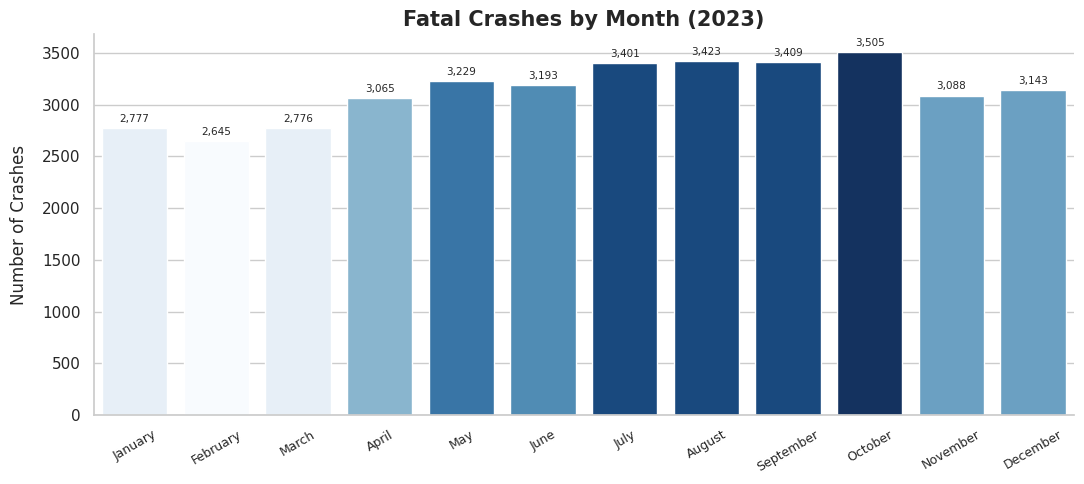

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 1️⃣ Define month order
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# 2️⃣ Get monthly crash counts (unique ST_CASE per month)
month_counts = (
    crash_df.groupby("MONTHNAME")["ST_CASE"]
    .nunique()
    .reindex(month_order)
)

# 3️⃣ Create a colormap ordered by counts
cmap = cm.get_cmap("Blues", len(month_counts))
norm = mcolors.Normalize(vmin=month_counts.min(), vmax=month_counts.max())
colors = [cmap(norm(v)) for v in month_counts]

# 4️⃣ Create a color mapping dict for Seaborn
month_palette = dict(zip(month_order, colors))

# 5️⃣ Plot with Seaborn (your same style)
fig, ax = plt.subplots(figsize=(11, 5))
sns.countplot(
    data=crash_df,
    x="MONTHNAME",
    order=month_order,
    hue="MONTHNAME",
    legend=False,
    palette=month_palette  # ← use intensity palette
)
ax.set_title("Fatal Crashes by Month (2023)", fontsize=15, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("Number of Crashes", labelpad=10)
ax.tick_params(axis="x", rotation=30, labelsize=9)
add_value_labels(ax)
plt.tight_layout()
plt.show()

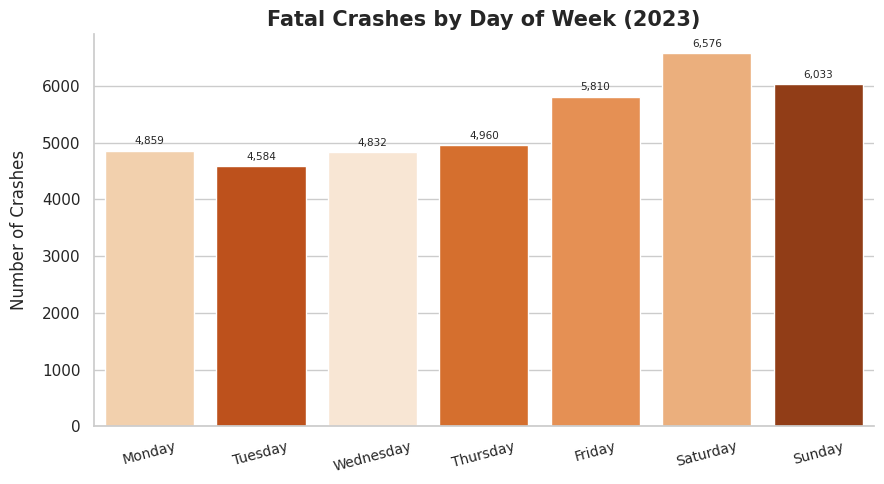

In [79]:
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

fig, ax = plt.subplots(figsize=(9, 5))
sns.countplot(
    data=crash_df,
    x="DAY_WEEKNAME",
    order=day_order,
    hue="DAY_WEEKNAME",   # fixes the warning
    legend=False,
    palette="Oranges"
)
ax.set_title("Fatal Crashes by Day of Week (2023)", fontsize=15, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("Number of Crashes", labelpad=10)
ax.tick_params(axis="x", rotation=15, labelsize=10)
add_value_labels(ax)
plt.tight_layout()
plt.show()

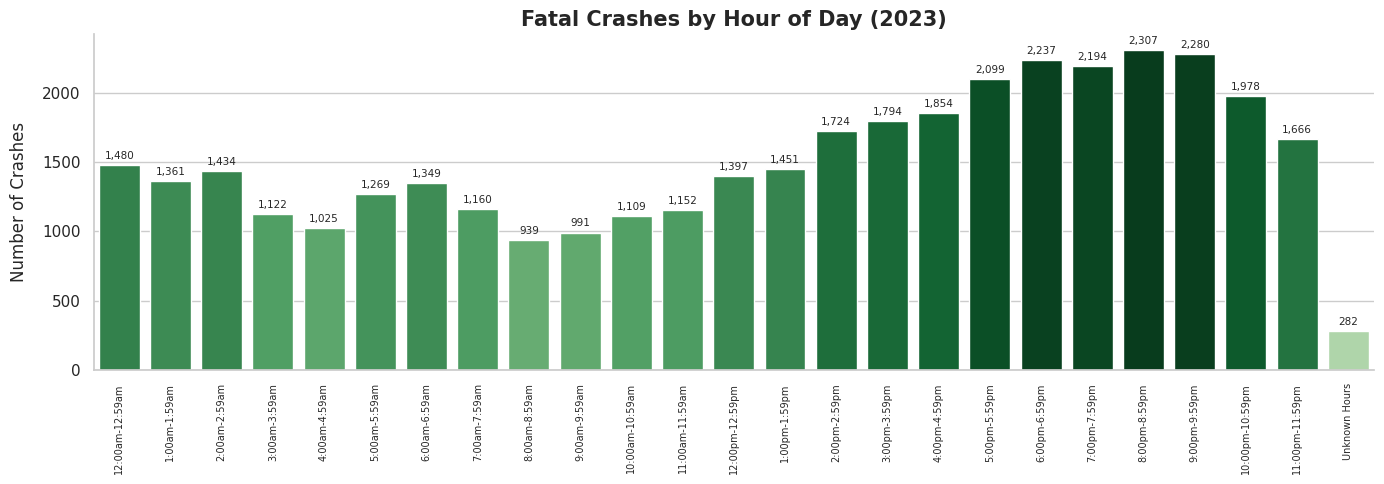

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re

# helper
def add_value_labels(ax, spacing=3):
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(
                f"{int(h):,}",
                (p.get_x() + p.get_width() / 2, h),
                ha="center", va="bottom",
                xytext=(0, spacing),
                textcoords="offset points",
                fontsize=7.5
            )

# your desired order (display order)
hour_order = [
    "12:00am-12:59am","1:00am-1:59am","2:00am-2:59am","3:00am-3:59am",
    "4:00am-4:59am","5:00am-5:59am","6:00am-6:59am","7:00am-7:59am",
    "8:00am-8:59am","9:00am-9:59am","10:00am-10:59am","11:00am-11:59am",
    "12:00pm-12:59pm","1:00pm-1:59pm","2:00pm-2:59pm","3:00pm-3:59pm",
    "4:00pm-4:59pm","5:00pm-5:59pm","6:00pm-6:59pm","7:00pm-7:59pm",
    "8:00pm-8:59pm","9:00pm-9:59pm","10:00pm-10:59pm","11:00pm-11:59pm"
]

# --- 1) make a copy and normalize hour strings ---
crash_df2 = crash_df.copy()
crash_df2["HOURNAME"] = crash_df2["HOURNAME"].astype(str).str.strip()

def normalize_hour_label(s):
    """
    Fix cases like '0:00am-0:59am' -> '12:00am-12:59am'
    and leave others as-is.
    """
    if not s:
        return s
    # common weird variant
    if s.lower().startswith("0:00am") or s.lower().startswith("0:00 am"):
        return "12:00am-12:59am"
    if s.lower().startswith("0:00pm") or s.lower().startswith("0:00 pm"):
        return "12:00pm-12:59pm"
    # sometimes it's '0:00am-0:59am' strictly
    if re.match(r"0:00am-0:59am", s.lower()):
        return "12:00am-12:59am"
    if re.match(r"0:00pm-0:59pm", s.lower()):
        return "12:00pm-12:59pm"
    return s

crash_df2["HOUR_STD"] = crash_df2["HOURNAME"].apply(normalize_hour_label)

# 2) figure out ALL hour labels actually present after normalization
actual_hours = sorted(crash_df2["HOUR_STD"].unique())

# 3) count crashes per hour (unique ST_CASE) using the normalized column
counts = (
    crash_df2.groupby("HOUR_STD")["ST_CASE"]
    .nunique()
    .to_dict()
)

# 4) build intensity palette for ALL actual labels
values = [counts.get(h, 0) for h in actual_hours]
vmin = min(values)
vmax = max(values) if max(values) > 0 else 1

cmap = matplotlib.colormaps.get_cmap("Greens")
palette = {}
for h in actual_hours:
    v = counts.get(h, 0)
    if v == 0:
        color = cmap(0.35)
    else:
        norm_val = (v - vmin) / (vmax - vmin) if vmax > vmin else 1.0
        color = cmap(0.35 + 0.65 * norm_val)
    palette[h] = color

# 5) final ordered x-axis: your 24 + any extras
extra_labels = [h for h in actual_hours if h not in hour_order]
final_order = hour_order + extra_labels

# 6) plot using the normalized column
fig, ax = plt.subplots(figsize=(14, 5))
sns.countplot(
    data=crash_df2,
    x="HOUR_STD",
    order=final_order,
    hue="HOUR_STD",
    legend=False,
    palette=palette
)
ax.set_title("Fatal Crashes by Hour of Day (2023)", fontsize=15, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("Number of Crashes", labelpad=10)
ax.tick_params(axis="x", rotation=90, labelsize=7)
add_value_labels(ax)
plt.tight_layout()
plt.show()

In [34]:
print("Total unique crashes:", crash_df["ST_CASE"].nunique())
print("Sum of all hour bins:", crash_df2["HOURNAME"].value_counts().sum())

Total unique crashes: 37654
Sum of all hour bins: 37654


/tmp/ipython-input-4036772799.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


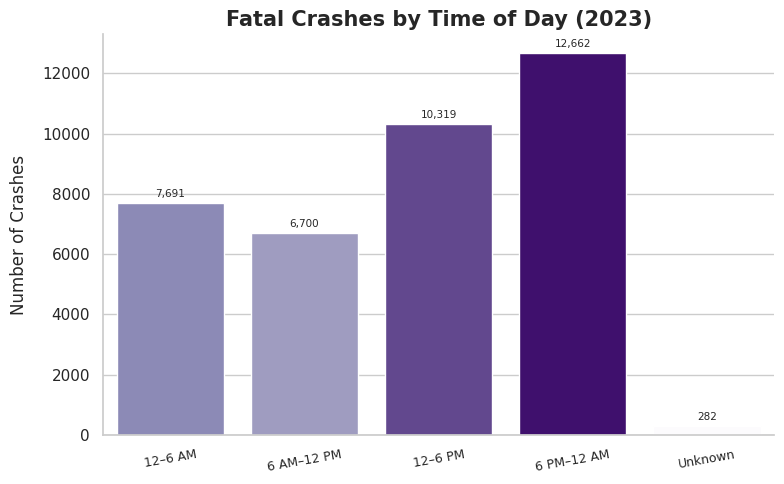

In [81]:
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

crash_df3 = crash_df.copy()

# your original bucket order (keep as-is)
bucket_order = [
    "Late Night (12–5 AM)",
    "Morning (6–11 AM)",
    "Afternoon (12–5 PM)",
    "Evening/Night (6–11 PM)",
    "Unknown"
]

# 1) make a display column with shorter/cleaner labels
label_map = {
    "Late Night (12–5 AM)": "12–6 AM",
    "Morning (6–11 AM)": "6 AM–12 PM",
    "Afternoon (12–5 PM)": "12–6 PM",
    "Evening/Night (6–11 PM)": "6 PM–12 AM",
    "Unknown": "Unknown"
}
crash_df3["HOUR_BUCKET_DISPLAY"] = crash_df3["HOUR_BUCKET"].map(label_map).fillna("Unknown")

# 2) counts in original order (so colors line up)
counts = crash_df3["HOUR_BUCKET"].value_counts().reindex(bucket_order, fill_value=0)

norm = Normalize(vmin=counts.min(), vmax=counts.max())
cmap = plt.cm.Purples
bucket_colors = {orig: cmap(norm(cnt)) for orig, cnt in zip(bucket_order, counts)}

# 3) plot using the display column, but tell seaborn the order in display terms
display_order = [label_map[b] for b in bucket_order]

fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(
    data=crash_df,
    x="HOUR_BUCKET_DISPLAY",
    order=display_order,
    palette=[bucket_colors[b] for b in bucket_order],  # keep color mapping aligned
    ax=ax
)

ax.set_title("Fatal Crashes by Time of Day (2023)", fontsize=15, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("Number of Crashes", labelpad=10)
ax.tick_params(axis="x", rotation=10, labelsize=9)

# make bars look continuous
ax.set_xlim(-0.5, len(display_order) - 0.5)

if "add_value_labels" in globals():
    add_value_labels(ax)

plt.tight_layout()
plt.show()


In [39]:
print("Total crashes in dataset:", crash_df["ST_CASE"].nunique())
# Verify monthly sum
month_counts = crash_df["MONTHNAME"].value_counts().sum()
print("Sum of all monthly bars:", month_counts)

day_counts = crash_df["DAY_WEEKNAME"].value_counts().sum()
print("Sum of all day-of-week bars:", day_counts)

hour_counts = crash_df["HOURNAME"].value_counts().sum()
print("Sum of all hour-of-day bars:", hour_counts)

Total crashes in dataset: 37654
Sum of all monthly bars: 37654
Sum of all day-of-week bars: 37654
Sum of all hour-of-day bars: 37654


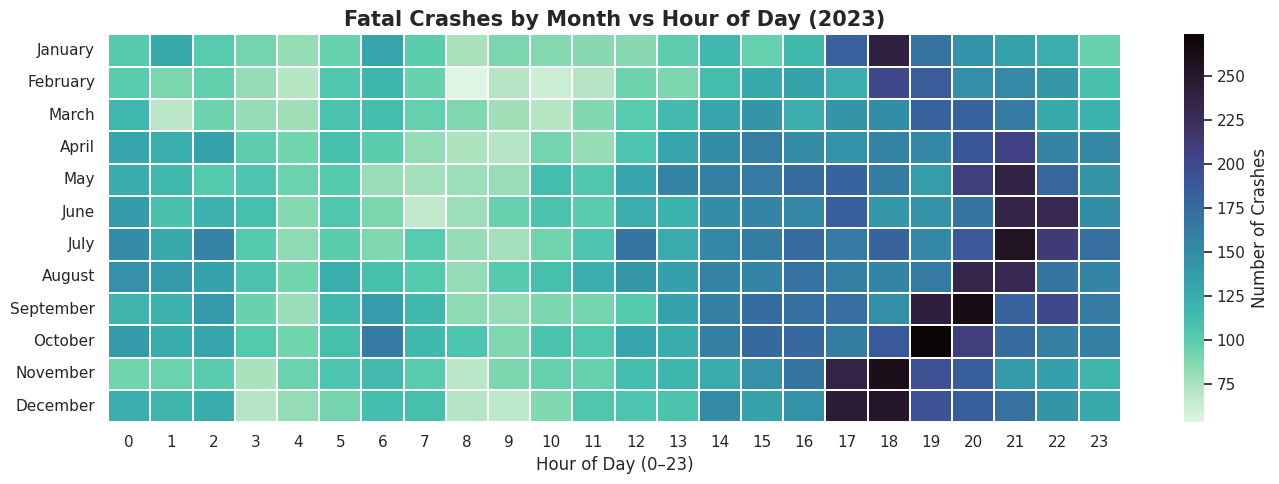

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# make a copy so we don't alter the original
df_month_hour = crash_df.copy()

# helper: convert hour text → 0–23
def hourname_to_24(h):
    if pd.isna(h):
        return np.nan
    part = h.split("-")[0].strip()
    ampm = part[-2:].lower()
    hour_str = part.split(":")[0]
    try:
        hour = int(hour_str)
    except ValueError:
        return np.nan
    if ampm == "pm" and hour != 12:
        hour += 12
    if ampm == "am" and hour == 12:
        hour = 0
    return hour

# derive hour in 24-hr format
df_month_hour["HOUR_24"] = df_month_hour["HOURNAME"].apply(hourname_to_24)

# ✅ convert to int to avoid .0 labels
df_month_hour["HOUR_24"] = df_month_hour["HOUR_24"].dropna().astype(int)

month_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]

# pivot for heatmap
month_hour = (
    df_month_hour
    .dropna(subset=["HOUR_24", "MONTHNAME"])
    .groupby(["MONTHNAME", "HOUR_24"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=month_order)
)

# ✅ ensure column names are integers
month_hour.columns = month_hour.columns.astype(int)

plt.figure(figsize=(14, 5))
sns.heatmap(
    month_hour,
    cmap="mako_r",  # 🔥 reversed for darker intensity at higher counts
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Number of Crashes"}
)
plt.title("Fatal Crashes by Month vs Hour of Day (2023)", fontsize=15, weight="bold")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


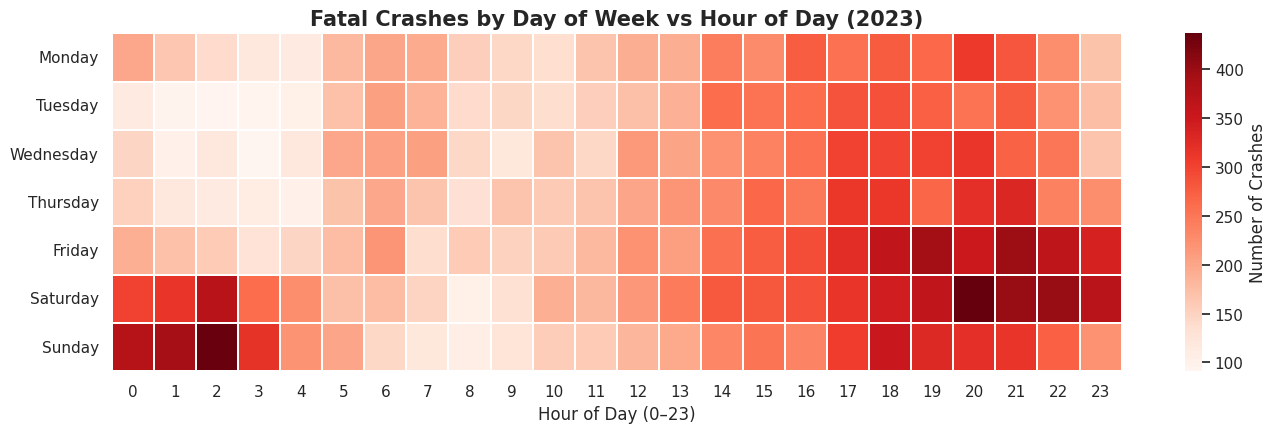

In [83]:
# make a copy so we don't alter the original
df_day_hour = crash_df.copy()

# reuse hour conversion
df_day_hour["HOUR_24"] = df_day_hour["HOURNAME"].apply(hourname_to_24)

# ✅ convert to int to remove .0 labels
df_day_hour["HOUR_24"] = df_day_hour["HOUR_24"].dropna().astype(int)

day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

day_hour = (
    df_day_hour
    .dropna(subset=["HOUR_24", "DAY_WEEKNAME"])
    .groupby(["DAY_WEEKNAME", "HOUR_24"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=day_order)
)

# ✅ ensure column names are ints for clean labels
day_hour.columns = day_hour.columns.astype(int)

plt.figure(figsize=(14, 4.5))

# 🔴 use a red-based, balanced palette — smooth gradient
sns.heatmap(
    day_hour,
    cmap="Reds",              # good red intensity palette
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Number of Crashes"}
)

plt.title("Fatal Crashes by Day of Week vs Hour of Day (2023)", fontsize=15, weight="bold")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [57]:
# mapping from FARS-style state names to 2-letter codes
state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME",
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
    "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
}

/tmp/ipython-input-3698121169.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


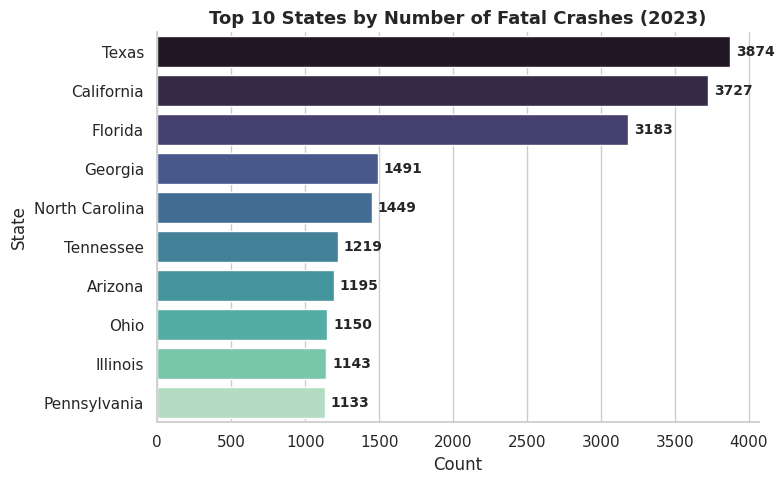

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# get top 10 states
top_states = acc_df['STATENAME'].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_states.values,
    y=top_states.index,
    palette="mako"   # ✅ same color tone as before
)
plt.title("Top 10 States by Number of Fatal Crashes (2023)", fontsize=13, weight="bold")
plt.xlabel("Count")
plt.ylabel("State")

# add values on bars
for i, v in enumerate(top_states.values):
    plt.text(v + max(top_states.values)*0.01, i, str(v), va='center', fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

# (optional tiny spacer figure)
plt.figure(figsize=(0.1, 0.1))
plt.axis('off')
plt.show()

/tmp/ipython-input-1246978122.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


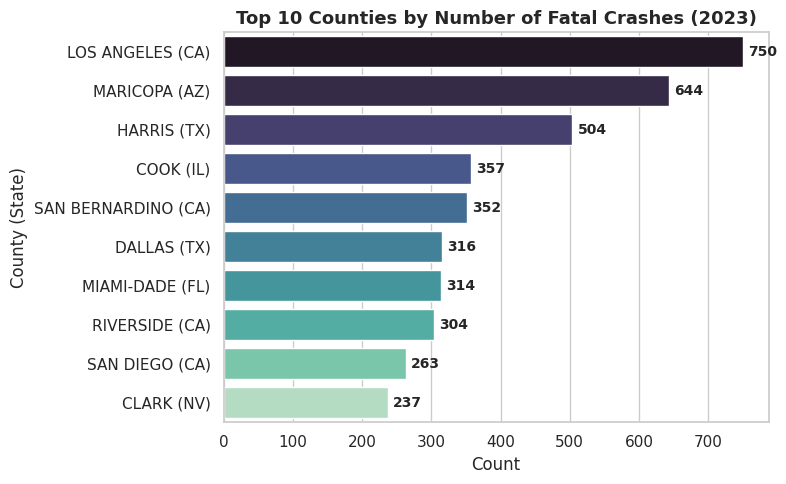

In [103]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

# make a copy
df_county = acc_df.copy()

# group by (STATENAME, COUNTYNAME)
county_counts = (
    df_county
    .groupby(["STATENAME", "COUNTYNAME"])
    .size()
    .reset_index(name="count")
)

# ✅ Clean county names (remove any digits or codes inside parentheses)
def clean_county_name(name):
    if pd.isna(name):
        return name
    # remove anything in parentheses e.g., "Maricopa (013)" → "Maricopa"
    return re.sub(r"\s*\([^)]*\)", "", str(name)).strip()

county_counts["COUNTYNAME"] = county_counts["COUNTYNAME"].apply(clean_county_name)

# create label "County (ST)"
county_counts["label"] = county_counts.apply(
    lambda row: f"{row['COUNTYNAME']} ({state_to_abbrev.get(row['STATENAME'], row['STATENAME'][:2].upper())})",
    axis=1
)

# get top 10
top_counties = (
    county_counts
    .sort_values("count", ascending=False)
    .head(10)
)

# plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_counties,
    x="count",
    y="label",
    palette="mako"
)
plt.title("Top 10 Counties by Number of Fatal Crashes (2023)", fontsize=13, weight="bold")
plt.xlabel("Count")
plt.ylabel("County (State)")

# add count labels
for i, v in enumerate(top_counties["count"].values):
    plt.text(v + max(top_counties["count"].values)*0.01, i, str(v),
             va='center', fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

/tmp/ipython-input-894638057.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


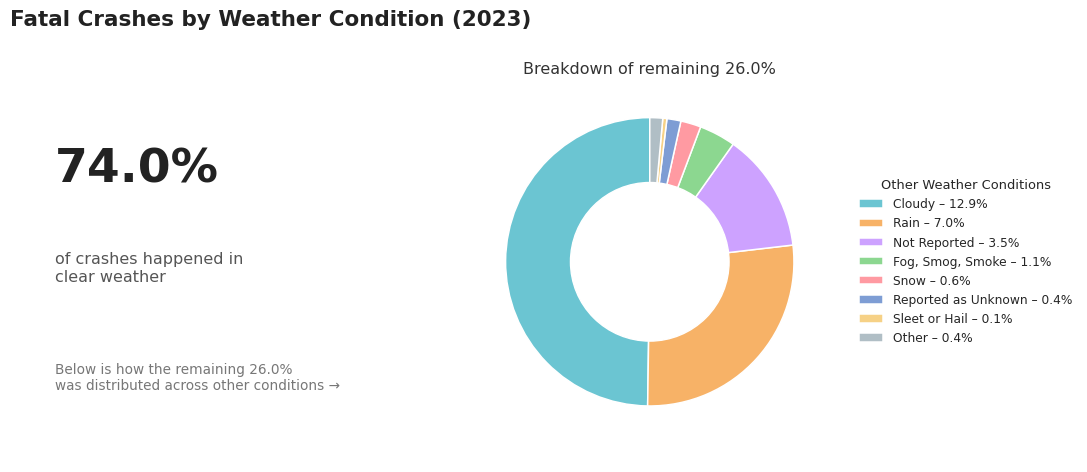

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

df_weather = acc_df.copy()
col_weather = "WEATHERNAME"

# 1) counts
weather_counts = (
    df_weather[col_weather]
    .fillna("Unknown")
    .replace("", "Unknown")
    .value_counts()
)

# 2) main condition
main_weather = weather_counts.index[0]
main_count = weather_counts.iloc[0]
total = weather_counts.sum()
main_pct = round(main_count / total * 100, 1)
remaining_pct = round(100 - main_pct, 1)

# 3) remaining buckets
other_weather = weather_counts.drop(index=main_weather)

if len(other_weather) > 7:
    top_rem = other_weather.head(7)
    other_sum = other_weather.iloc[7:].sum()
    other_weather = pd.concat([top_rem, pd.Series({"Other": other_sum})])

other_pct = (other_weather / total * 100).round(1)
labels = [f"{name} – {pct:.1f}%" for name, pct in zip(other_weather.index, other_pct)]

# softer, aesthetic palette (muted, distinct)
colors = [
    "#6BC5D2",  # teal blue
    "#F7B267",  # soft orange
    "#CDA2FF",  # lilac
    "#8CD790",  # green
    "#FF9AA2",  # pink
    "#7E9DD4",  # steel blue
    "#F6D186",  # pastel yellow
    "#B0BEC5",  # grey
]

# FIGURE
fig = plt.figure(figsize=(10, 5.2), facecolor="white")
gs = gridspec.GridSpec(1, 2, width_ratios=[1.05, 1.05], wspace=0.15)

# LEFT PANEL: KPI
ax0 = plt.subplot(gs[0])
ax0.axis("off")

# big number
ax0.text(
    0.0, 0.7,
    f"{main_pct}%",
    fontsize=34,
    fontweight="bold",
    color="#222222"
)
# description
ax0.text(
    0.0, 0.45,
    f"of crashes happened in\n{main_weather.lower()} weather",
    fontsize=11.5,
    color="#555555",
    linespacing=1.3
)
# connector text
ax0.text(
    0.0, 0.18,
    f"Below is how the remaining {remaining_pct}%\nwas distributed across other conditions →",
    fontsize=9.8,
    color="#777777",
    linespacing=1.25
)

# RIGHT PANEL: donut
ax1 = plt.subplot(gs[1])
wedges, _ = ax1.pie(
    other_weather.values,
    startangle=90,
    colors=colors[:len(other_weather)],
    wedgeprops={"edgecolor": "white", "linewidth": 1.1},
)

# donut hole
centre_circle = plt.Circle((0, 0), 0.55, fc="white")
ax1.add_artist(centre_circle)

ax1.set_title(
    f"Breakdown of remaining {remaining_pct}%",
    fontsize=11.5,
    pad=6,
    color="#333333"
)

# legend neatly to the right
legend = ax1.legend(
    wedges,
    labels,
    title="Other Weather Conditions",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    fontsize=8.8,
    title_fontsize=9.4
)

# GLOBAL TITLE
plt.suptitle(
    "Fatal Crashes by Weather Condition (2023)",
    fontsize=15.5,
    fontweight="bold",
    x=0.08,  # shift a bit to the left to align with text block
    ha="left",
    color="#222222"
)

plt.tight_layout(pad=2.0)
plt.show()


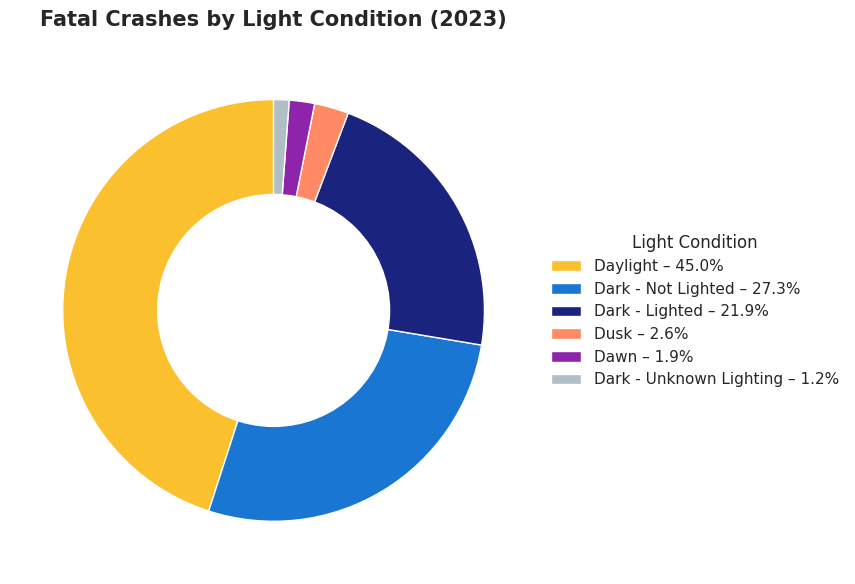

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# work on a copy
df_light = acc_df.copy()

col_light = "LGT_CONDNAME"

# get counts
light_counts = (
    df_light[col_light]
    .fillna("Unknown")
    .replace("", "Unknown")
    .value_counts()
)

# keep top 6 to avoid overcrowding
light_counts = light_counts.head(6)

# total for percentages
total = light_counts.sum()
percent_labels = [f"{idx} – {val/total*100:.1f}%" for idx, val in light_counts.items()]

# more distinct, semantic colors
colors = [
    "#FBC02D",  # daylight - golden
    "#1976D2",  # dark - lighted - blue
    "#1A237E",  # dark - not lighted - deep navy
    "#FF8A65",  # dawn - warm
    "#8E24AA",  # dusk - purple
    "#B0BEC5",  # unknown - grey
]

plt.figure(figsize=(9, 6))

# donut pie (no labels, we'll use legend)
wedges, _ = plt.pie(
    light_counts.values,
    startangle=90,
    colors=colors[:len(light_counts)],
    wedgeprops={"edgecolor": "white", "linewidth": 1},
)

# center hole
centre_circle = plt.Circle((0, 0), 0.55, fc="white")
plt.gca().add_artist(centre_circle)

plt.title("Fatal Crashes by Light Condition (2023)", fontsize=15, weight="bold", pad=15)

# legend on the right with names + %
plt.legend(
    wedges,
    percent_labels,
    title="Light Condition",
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    frameon=False,
)

plt.tight_layout()
plt.show()


/tmp/ipython-input-1721267513.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(pct.index, rotation=20, ha="right")


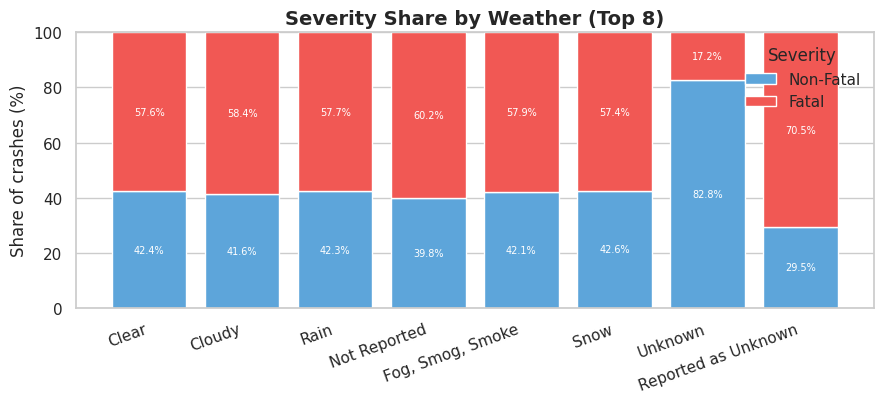

/tmp/ipython-input-1721267513.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(pct.index, rotation=20, ha="right")


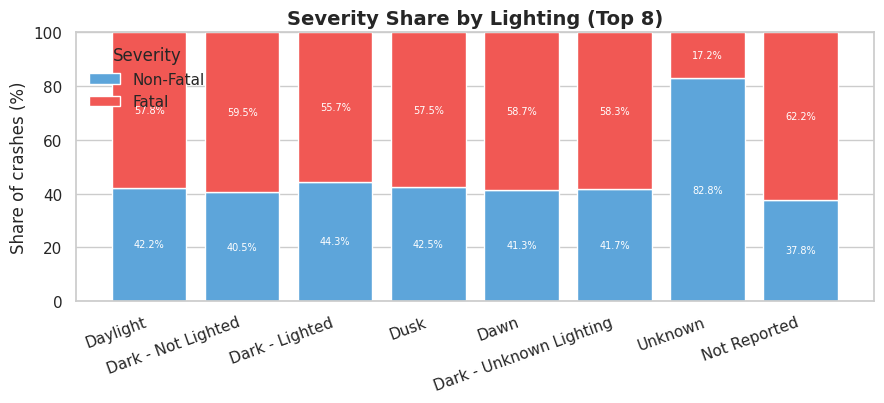

Total unique crashes: 37654


In [102]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df.copy()
df["WEATHERNAME"] = df["WEATHERNAME"].fillna("Unknown").astype(str).str.strip()
df["LGT_CONDNAME"] = df["LGT_CONDNAME"].fillna("Unknown").astype(str).str.strip()
df["INJ_SEVNAME"] = df["INJ_SEVNAME"].astype(str)

def to_severity(x: str) -> str:
    return "Fatal" if "fatal" in x.lower() else "Non-Fatal"

df["SEVERITY"] = df["INJ_SEVNAME"].apply(to_severity)

# ------------------------------------------------------------------
# 1) helper to build a 100% stacked bar for a column
# ------------------------------------------------------------------
def plot_severity_share(df, col, title, top_n=8):
    # count crashes
    grouped = (
        df.groupby([col, "SEVERITY"])["ST_CASE"]
          .nunique()
          .reset_index(name="Crashes")
    )
    # keep top N categories by total crashes
    top_order = (
        grouped.groupby(col)["Crashes"]
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )
    grouped = grouped[grouped[col].isin(top_order)]

    # pivot to Fatal / Non-Fatal columns
    pivot = grouped.pivot(index=col, columns="SEVERITY", values="Crashes").fillna(0)
    pivot = pivot.loc[top_order]  # preserve order
    # compute row-wise percentages
    pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

    # plot
    fig, ax = plt.subplots(figsize=(9, 4.2))
    ax.bar(pct.index, pct["Non-Fatal"], label="Non-Fatal", color="#5DA5DA")
    ax.bar(pct.index, pct.get("Fatal", 0), bottom=pct["Non-Fatal"], label="Fatal", color="#F15854")

    # labels
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylabel("Share of crashes (%)")
    ax.set_ylim(0, 100)
    ax.set_xticklabels(pct.index, rotation=20, ha="right")
    ax.legend(title="Severity", frameon=False)

    # show exact % on bars
    for i, cat in enumerate(pct.index):
        nf = pct.loc[cat, "Non-Fatal"]
        ft = pct.loc[cat, "Fatal"] if "Fatal" in pct.columns else 0
        if ft > 3:
            ax.text(i, nf + ft/2, f"{ft:.1f}%", ha="center", va="center", fontsize=7, color="white")
        if nf > 5:
            ax.text(i, nf/2, f"{nf:.1f}%", ha="center", va="center", fontsize=7, color="white")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 2) call it for weather and lighting
# ------------------------------------------------------------------
plot_severity_share(df, "WEATHERNAME", "Severity Share by Weather (Top 8)")
plot_severity_share(df, "LGT_CONDNAME", "Severity Share by Lighting (Top 8)")

# optional: your old sanity checks still good
print("Total unique crashes:", df["ST_CASE"].nunique())
